# meta-VQE

Hot to obtain a Potential Energy Surface (PES) plot without training for *all* the points of interest.

## Keypoints

* For a molecule, the Hamiltonian depends on the geometry (separation) of the atoms or nuclei
* For simple, vanilla VQE, all the possible configurations (separations) in the molecule need to be trained separately
* meta-VQE trains a few points (training points), encoding the original parameters $\vec{\theta}$ using metaparamers and a linear or Gaussian encoding.

The code below uses Catalyst (from Xanadu) and JAX to optimize calculations

In [1]:
import catalyst
from catalyst import qjit

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, OptimizeResult

import jax.numpy as jnp

In [2]:
## Layers and wires for circuits

symbols = ["Li", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Building the molecular hamiltonian for LiH
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method="pyscf",
)

LAYERS = 1
WIRES = qubits

## https://docs.pennylane.ai/projects/catalyst/en/latest/code/api/catalyst.grad.html - ["fd", "ps", "adj"]
GRADIENT_METHOD= "fd"

TRAINING_ENERGIES= {"gradient_descent":{"energies":[], "trained_meta_vars":[]},
                    "spsa":{"energies":[], "trained_meta_vars":[]},
                    "adam":{"energies":[], "trained_meta_vars":[]},
                   }

# Encoder: 
# Linear -> 1
# Gaussian -> 2

ENCODER_MULTIPLIER_DICT = {1:2,
                      2:4}

ENCODER = 2

shared_dev = qml.device("lightning.qubit", wires=WIRES)

symbols = ["Li", "H"]

train_points = [1.0,2.0,3.0,4.0,5.0]

test_points = np.arange(0.6,6,0.2)

test_hamiltonians = []

for d in test_points:
    symbols = ["Li", "H"]
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, d]) 
    
    hamiltonian, _ = qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        method="pyscf",
    )    
    
    test_hamiltonians.append(hamiltonian)
    


In [ ]:
## Get Full COnfiguration Integration (FCI) data to compare
## Notice there are several ways to run FCI in pyscf: https://pyscf.org/user/ci.html
import pyscf
fci_energies = []

for d in test_points:
    mol = pyscf.M(
    atom = 'Li 0 0 0; H 0 0 {0}'.format(d),
    basis = 'sto3g',
    unit="Bohr",       charge= 0,
    spin= 0   
    )

    myhf = mol.RHF().run()

    cisolver = pyscf.fci.FCI(myhf)
    fci_energies.append(cisolver.kernel()[0])

### Linear Encoding

$\theta_{i} = w_{i} \, R + \phi_{i}$

In [3]:
def linear_encoding(param_array, r):
    """1-D array with alphas and betas. len(param_array) = 2 * len(weights) 

    Args:
        param_array (float): alphas and betas for lineasr encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """
    return param_array[::2]*r + param_array[1::2]

### Gaussian Encoding

$\theta_{i} = \alpha_{i} e^{\beta_{i} (\gamma_{i} - R)} + \delta_{i}$

In [4]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*(param_array[2::4] - r)

    return param_array[::4]*jnp.exp(exp_arg) + param_array[3::4]

In [5]:
## Get shapes

## For linear is 2
## For Gaussian is 4
ENCODING_MULTIPLIER= ENCODER_MULTIPLIER_DICT[ENCODER]

if(ENCODER == 1):
    ENCODER_FUNC =linear_encoding
else:
    ENCODER_FUNC =gaussian_encoding

num_params = (WIRES + LAYERS*(WIRES-1)*2)*ENCODING_MULTIPLIER

shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=WIRES)
weights = np.random.random(num_params)

print("===== NUM OF PARAMETERS =====")
print(num_params)

===== NUM OF PARAMETERS =====
136


In [6]:
##Run for all points without training

@qml.qnode(shared_dev)
def catalyst_simplified_two_design(params, hamiltonian):

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=WIRES)

    init_weights, weights = np.reshape(params[:qubits],shapes[0]), np.reshape(params[qubits:],shapes[1])

    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(WIRES))

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  

### Cost Function

Sum of energies for each configuration (separation)

$C(\vec{\theta}) = \sum_{i=1}^{M} \bra{\psi_{i}} \hat{H}(\vec{\lambda}_{i}) \ket{\psi_{i}}$


In [7]:
from jax.core import ShapedArray

@qjit
def energy_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    energies = []   

    for r in train_points:
   
        def catalyst_simplified_two_design(params):
        
            symbols = ["Li", "H"]
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(catalyst_simplified_two_design, shared_dev)
        
        energies.append(circuit(params))
        
    join_energy = jnp.sum(jnp.array(energies))


    
    return join_energy/len(train_points) 

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 2.]
[0. 0. 0. 0. 0. 3.]
[0. 0. 0. 0. 0. 4.]
[0. 0. 0. 0. 0. 5.]


### Circuit gradients

In [8]:
from jax.core import ShapedArray

@qjit
def gradient_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    gradients = []

    for r in train_points:
   
        def catalyst_simplified_two_design(params):
        
            symbols = ["Li", "H"]
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(catalyst_simplified_two_design, shared_dev)
        
        gradients.append(catalyst.grad(circuit, method = GRADIENT_METHOD )(params))
        
    all_gradients = jnp.array(gradients)
    joined_gradients = jnp.sum(jnp.array([all_gradients[i][0] for i in range(len(all_gradients))]), axis=0)

    
    return joined_gradients/len(train_points)

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 2.]
[0. 0. 0. 0. 0. 3.]
[0. 0. 0. 0. 0. 4.]
[0. 0. 0. 0. 0. 5.]


In [9]:
energy_simplified_two_design(weights)


Array(-3.32853482, dtype=float64)

In [10]:
gradient_simplified_two_design(weights)

Array([-2.25745793e-01,  1.24338824e-02, -5.95356653e-03, -7.27517772e-01,
       -9.42972521e-01,  7.18287256e-01, -1.85356770e-02, -1.12794080e+00,
        2.75204905e-01, -2.59335527e-01,  5.41880398e-02,  4.15432628e-01,
       -7.79683269e-02,  3.12045962e-02, -2.66144973e-02, -1.36943948e-01,
        2.46659138e-02, -3.02961212e-04,  1.25650601e-05,  3.30109415e-02,
       -9.79428272e-03,  5.07699127e-03, -1.38138301e-03, -2.44228717e-02,
        4.99351405e-03, -1.54031188e-03,  7.72833353e-04,  2.81717192e-02,
       -1.02779056e-02,  1.04761551e-02, -2.74884027e-03, -1.79334858e-02,
       -9.96033567e-03,  3.64709152e-04, -2.62182276e-04, -1.52484834e-02,
       -1.44751713e-02,  2.70331535e-02, -3.02550873e-04, -1.50926702e-02,
       -3.07654391e-02,  5.43499734e-03, -1.04024043e-02, -5.26643280e-02,
        9.45786880e-02, -8.89909968e-02,  5.54736941e-02,  1.96234801e-01,
       -7.15302048e-01,  3.02420561e-01, -4.55802951e-03, -7.87941208e-01,
       -4.26455567e-01,  

In [11]:
def gradient_descent(fun,x0, stepsize=0.1, tol=1e-4,maxiter=100, verbose = False, **options):

    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]    

    niter = 0

    for i in range(maxiter):
        niter +=1
        grad = gradient_simplified_two_design(new_params)

        new_params -= grad*stepsize

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)
        
        if(verbose and i%10 == 0):
            print("Gradient Descent - Step: ", i, " Cost: ", new_energy)

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["gradient_descent"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["gradient_descent"]["trained_meta_vars"].append(new_params)
    
    print("Finished Gradient Descent training")

    return OptimizeResult(x=new_params, nit=niter)


In [12]:
def spsa_optimizer(fun, x0, maxiter=100,alpha=0.602,gamma=0.101, c=0.2, A=None, a=None, tol=1e-4, verbose = False, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]       

    if not A:
        A = maxiter * 0.1

    if not a:
        a = 0.05 * (A + 1) ** alpha        

    niter = 0

    for i in range(maxiter):
        niter +=1

        ak=a/np.power(i+1+A,alpha)
        ck=c/np.power(i+1,gamma)

        delta = np.random.choice([-1, 1], size=x0.shape)

        thetaplus=new_params+ck*delta
        thetaminus=new_params-ck*delta
        yplus=energy_simplified_two_design(thetaplus)
        yminus=energy_simplified_two_design(thetaminus)  

        grad = jnp.array([(yplus - yminus) / (2 * ck * di) for di in delta]  )

        new_params -= ak*grad

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)  
        
        if(verbose and i%10 == 0):
            print("SPSA - Step: ", i, " Cost: ", new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["spsa"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["spsa"]["trained_meta_vars"].append(new_params)  
    
    print("Finished SPSA training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [13]:
def adam(fun, x0, maxiter=100,stepsize=0.01, beta1=0.9, beta2=0.99, tol=1e-4,eps=1e-08, verbose = False, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy] 
      
    m = jnp.zeros_like(x0)
    v = jnp.zeros_like(x0)

    niter = 0

    for i in range(maxiter):
        niter +=1

        grad = gradient_simplified_two_design(new_params)

        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*jnp.square(grad)

        mhat = m/(1-beta1**(i+1))

        vhat = v/(1-beta2**(i+1))

        step = mhat/(jnp.array([np.sqrt(vhat_i) + eps for vhat_i in vhat]) )


        new_params -= stepsize*step

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)     
        
        if(verbose and i%10 == 0):
            print("ADAM - Step: ", i, " Cost: ", new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["adam"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["adam"]["trained_meta_vars"].append(new_params)  
    
    print("Finished ADAM training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [14]:
res_gradient = minimize(energy_simplified_two_design, weights, method = gradient_descent, options = {'maxiter': 200, 'tol':1e-5, 'verbose':True})
res_spsa = minimize(energy_simplified_two_design, weights, method = spsa_optimizer, options = {'maxiter': 200, 'tol':1e-5, 'verbose':True})
res_adam = minimize(energy_simplified_two_design, weights, method = adam, options = {'maxiter': 200, 'tol':1e-5, 'verbose':True})

Gradient Descent - Step:  0  Cost:  -4.196150850690349
Gradient Descent - Step:  10  Cost:  -6.391984824129028
Gradient Descent - Step:  20  Cost:  -7.08330512157147
Gradient Descent - Step:  30  Cost:  -7.302380179958497
Gradient Descent - Step:  40  Cost:  -7.377970712213511
Gradient Descent - Step:  50  Cost:  -7.411014103745825
Gradient Descent - Step:  60  Cost:  -7.430296573017583
Gradient Descent - Step:  70  Cost:  -7.443755426113685
Gradient Descent - Step:  80  Cost:  -7.454062370303478
Gradient Descent - Step:  90  Cost:  -7.462337293169808
Gradient Descent - Step:  100  Cost:  -7.469162037407843
Gradient Descent - Step:  110  Cost:  -7.474894003600369
Gradient Descent - Step:  120  Cost:  -7.479778042640831
Gradient Descent - Step:  130  Cost:  -7.483992068448489
Gradient Descent - Step:  140  Cost:  -7.487668893713321
Gradient Descent - Step:  150  Cost:  -7.490908722929722
Gradient Descent - Step:  160  Cost:  -7.493787537457256
Gradient Descent - Step:  170  Cost:  -7.49

<function matplotlib.pyplot.show(close=None, block=None)>

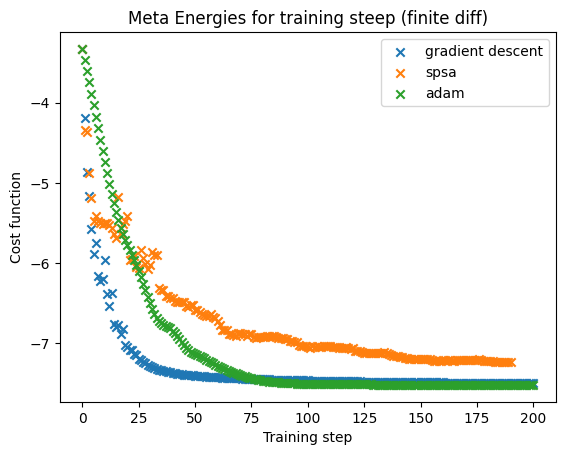

In [15]:
plt.scatter([i for i in range(len(TRAINING_ENERGIES['gradient_descent']['energies'][-1]))],TRAINING_ENERGIES['gradient_descent']['energies'][-1], label="gradient descent", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['spsa']['energies'][-1]))],TRAINING_ENERGIES['spsa']['energies'][-1], label="spsa", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['adam']['energies'][-1]))],TRAINING_ENERGIES['adam']['energies'][-1], label="adam", marker='x')

plt.legend()
plt.title('Meta Energies for training steep (finite diff)')
plt.ylabel('Cost function')
plt.xlabel('Training step')
plt.show

In [22]:
trained_energies = {"gradient_descent":[], "spsa":[], "adam":[]}

for count, d in enumerate(test_points):
    print(d)
    for k in trained_energies:
        if ENCODER == 1:
            encoded_params = linear_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)
        else:
            encoded_params = gaussian_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)
        energy= catalyst_simplified_two_design(encoded_params,test_hamiltonians[count])
        trained_energies[k].append(energy)

0.6
0.8
1.0
1.2000000000000002
1.4000000000000004
1.6000000000000005
1.8000000000000003
2.0000000000000004
2.2000000000000006
2.400000000000001
2.600000000000001
2.8000000000000007
3.000000000000001
3.200000000000001
3.400000000000001
3.600000000000001
3.800000000000001
4.000000000000001
4.200000000000001
4.400000000000001
4.600000000000001
4.800000000000001
5.000000000000001
5.200000000000001
5.400000000000001
5.600000000000001
5.800000000000002


<function matplotlib.pyplot.show(close=None, block=None)>

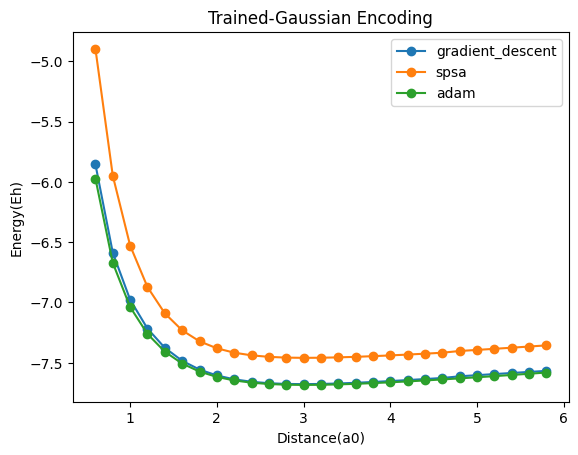

In [24]:
plt.plot(test_points, trained_energies["gradient_descent"], label="gradient_descent", marker='o')
plt.plot(test_points, trained_energies["spsa"], label="spsa", marker='o')
plt.plot(test_points, trained_energies["adam"], label="adam", marker='o')
plt.plot(test_points, fci_energies, label="FCI", marker='-', color="r")


plt.legend()
plt.title('Trained-Gaussian Encoding')
plt.xlabel('Distance(a0)')
plt.ylabel('Energy(Eh)')
plt.show